In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
# coding=utf-8

import argparse
import os
import sys

import numpy as np
import pandas as pd
import h5py

import keras.backend as K
from keras.models import model_from_json

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

try:
    from evolutron.engine import DeepTrainer
    from evolutron.networks import custom_layers
    from evolutron.tools import aa2hot, Handle, load_dataset, shape, file_db
    from evolutron.tools.data_tools import pad_or_clip_seq
except ImportError:

    sys.path.insert(0, os.path.abspath('..'))
    from evolutron.engine import DeepTrainer
    from evolutron.networks import custom_layers
    from evolutron.tools import aa2hot, Handle, load_dataset, shape, file_db
    from evolutron.tools.data_tools import pad_or_clip_seq

Using Theano backend.


In [55]:
model = 'crispr/100_30_102_1_1_DeepCoDER.model'
handle = Handle.from_filename(model)
with np.load('embeddings/' + handle.dataset + '/' + handle.filename.split('.')[0] + '.embed.npz') as f:
    emb = f['arr_0']
print('Loaded embeddings')

proteins = pd.read_hdf('datasets/' + file_db[handle.dataset].split('.')[0] + '.h5', 'raw_data')
embeddings = pd.DataFrame(emb, index=proteins.index, columns=['Emb{}'.format(i) for i in range(emb.shape[1])])
assert (len(embeddings) == len(proteins))
proteins = pd.concat([proteins, embeddings], axis=1)

proteins = proteins.sample(n=200).reset_index(drop=True)

Loaded embeddings


In [56]:
embn = proteins[['Emb{}'.format(i) for i in range(emb.shape[1]) ]].as_matrix()

In [57]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, to_tree

In [58]:
# dist = pdist(emb, 'hamming')

In [60]:
Z = linkage(embn, 'weighted', metric='hamming')

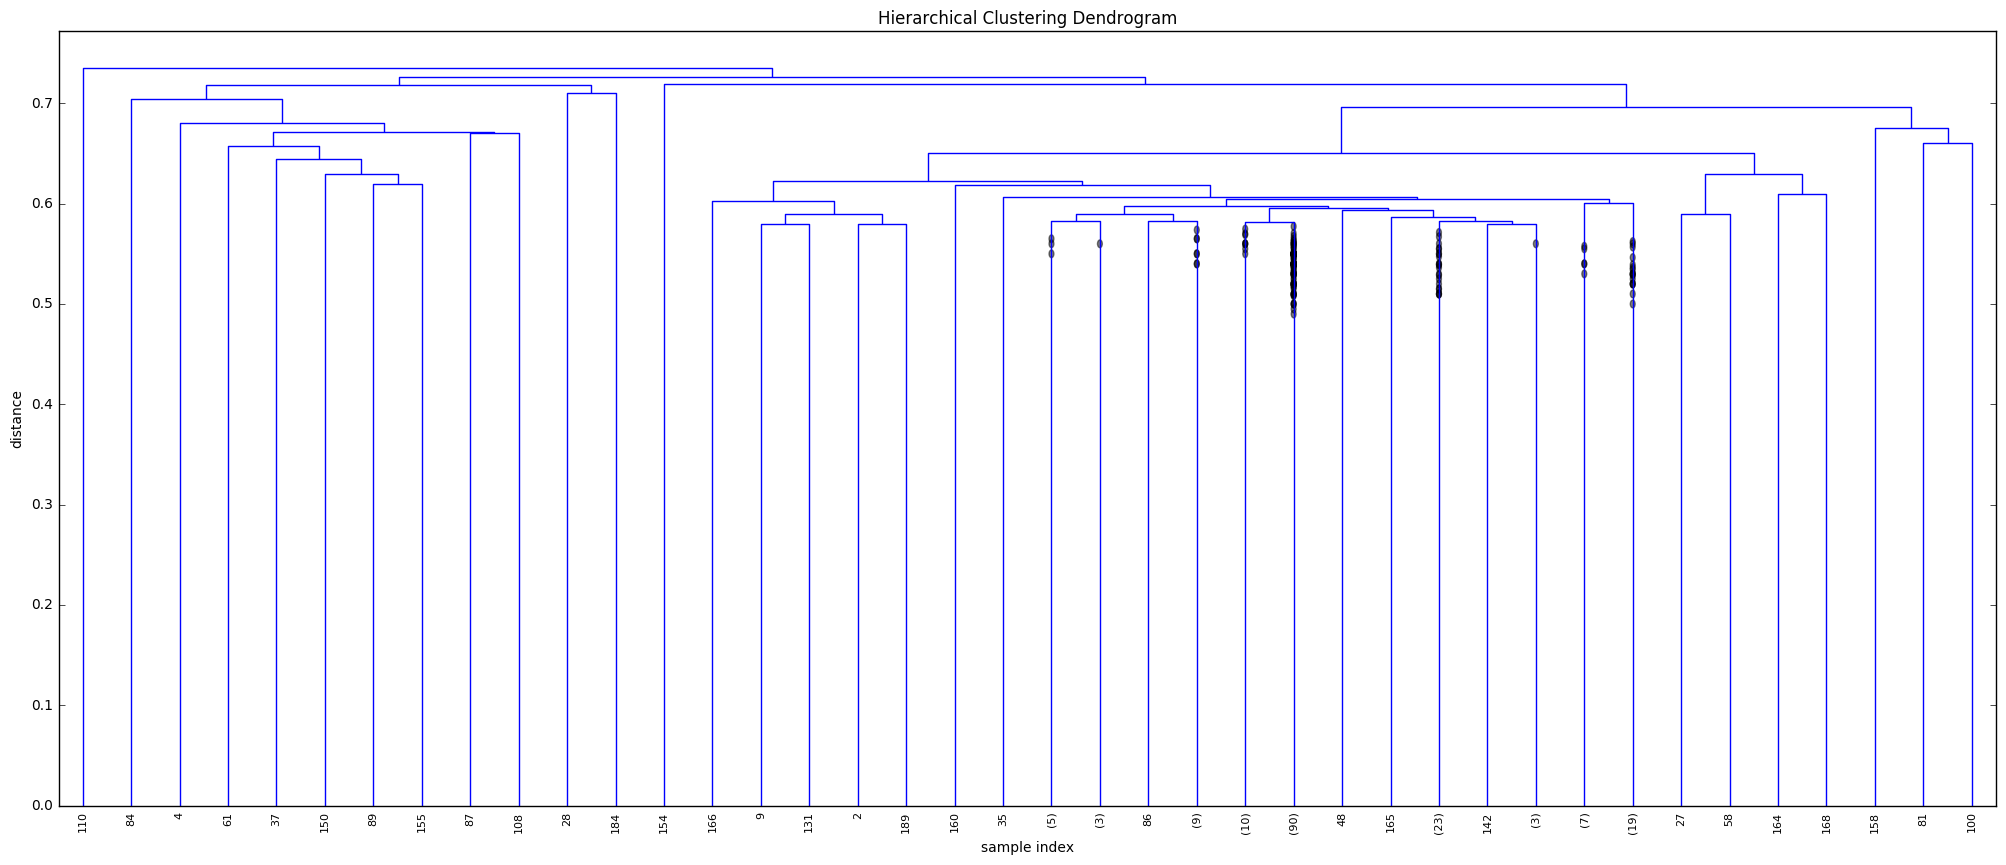

In [61]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
    truncate_mode='lastp',
    p=40
)
plt.show()

In [39]:
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

In [62]:
tree = to_tree(Z, False)
names = proteins['protein_names'].str.replace('CRISPR-associated','').str.replace('\(EC 3.1.-.-\)','')\
.str.replace('endonuclease','').tolist()
getNewick(tree, "", tree.dist,names)

'((((((  Cas1, subtype II/NMENI:0.66,  Cas6/Csy4 :0.66):0.02,  Cas1, subtype II/NMENI-like protein:0.68):0.02,(((  Cas1 :0.61,  Cas1 :0.61):0.02,(  Cas1 :0.59,  Cas1 :0.59):0.04):0.02,((((((((  Cas1 :0.56,  Cas1 :0.56):0.00,((((((((  Cas1 :0.52,  Cas1 :0.52):0.00,  Cas1 :0.52):0.01,  Cas1 :0.53):0.00,  Cas1 :0.53):0.01,  Cas1 :0.53):0.00,(  Cas1 :0.53,  Cas1 :0.53):0.01):0.01,(((  Cas1 :0.53,  Cas1 :0.53):0.00,(((  Cas1 :0.50,  Cas1 :0.50):0.01,  Cas1 :0.51):0.01,  Cas1 :0.52):0.01):0.01,  Cas1 :0.54):0.01):0.01,  Cas1 :0.56):0.01):0.02,  Cas1 :0.58):0.02,((((  Cas1 :0.54,  Cas1 :0.54):0.02,  Cas1 :0.56):0.00,((  Cas1 :0.53,  Cas1 :0.53):0.01,  Cas1 :0.54):0.02):0.00,  Cas1 :0.56):0.04):0.00,((((((((Putative   Cas1:0.56,  Cas1 :0.56):0.00,  Cas1:0.56):0.02,  Cas1 :0.58):0.00,((((((  Cas1 :0.55,  Cas1 :0.55):0.01,(  Cas1 :0.55,  Cas1 :0.55):0.01):0.01,  Cas1 :0.56):0.01,(((((((((((  Cas1 :0.51,  Cas1 :0.51):0.01,  Cas1 :0.52):0.01,((  Cas1 :0.51,  Cas1 :0.51):0.01,(  Cas1 :0.51,  Cas1 :